In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import utils

# Example 1: Diffusion (random transitions) with Rewards in corners

In [2]:
# define the enviornment
n_rows, n_columns = 20, 20

sparse_diffusion_matrix = utils.make_diffision_transition_matrix(n_rows, n_columns, sparse=True)

tiling = utils.define_lattice_tiling(n_rows, n_columns,)

R = np.ones(n_rows * n_columns) * 0
gamma = 0.8
R[0] = 1.0
R[n_columns-1] = 1.0 
R[-1] = 1.0
R[-n_columns] = 1.0

V_0 = utils.draw_random_rewards(n_rows, n_columns, stdev=0.1)
V_a = V_0[:R.shape[0] // 2]
V_b = V_0[R.shape[0] // 2:]

k = 10
V_estimates = np.zeros((R.shape[0], k+1))
V_estimates[tiling, 0] = V_a
V_estimates[~tiling, 0] = V_b


# dynamic programming algorithm
for ii in range(1, k+1):
    V_a =  R[tiling] + gamma * sparse_diffusion_matrix[tiling][:, ~tiling].dot(V_b)
    V_b =  R[~tiling] + gamma * sparse_diffusion_matrix[~tiling][:, tiling].dot(V_a)

    # save reward functions for measurements
    V_estimates[tiling, ii] = V_a
    V_estimates[~tiling, ii] = V_b

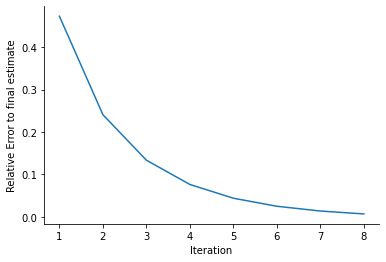

In [3]:
error = np.linalg.norm(V_estimates[:,:k-1] -  np.tile(V_estimates[:, -1].reshape(-1, 1), (1, k-1)), axis=0)
plt.plot(np.arange(1, len(error)), error[1:] / np.max(error))
plt.ylabel('Relative Error to final estimate')
plt.xlabel('Iteration')
sns.despine()

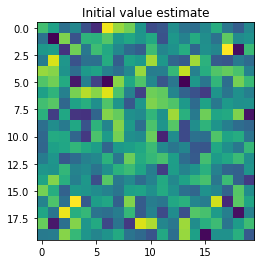

In [4]:
plt.imshow(V_estimates[:,0].reshape(n_rows, n_columns), cmap='viridis')
plt.title('Initial value estimate')
plt.savefig('2dDrift_v0.pdf', dpi=300)

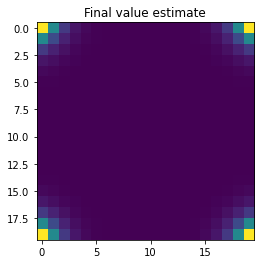

In [5]:
plt.title('Final value estimate')
plt.imshow(V_estimates[:,k-1].reshape(n_rows, n_columns), cmap='viridis', vmin=0, vmax=1)
plt.savefig('2dDrift_vf.pdf', dpi=300)

# Example 2: 1D Diffusion with Reward on one end

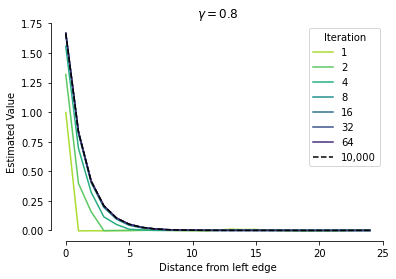

In [6]:
# define the enviornment
n_rows, n_columns = 1, 25

sparse_diffusion_matrix = utils.make_diffision_transition_matrix(n_rows, n_columns, sparse=True)

tiling = utils.define_lattice_tiling(n_rows, n_columns,)

R = np.ones(n_rows * n_columns) * 0
gamma = 0.8
R[0] = 1.0


V_0 = utils.draw_random_rewards(n_rows, n_columns, stdev=0.01)
V_a = V_0[:R.shape[0] // 2]
V_b = V_0[R.shape[0] // 2:]

k = 10000
V_estimates = np.zeros((R.shape[0], k+1))
V_estimates[tiling, 0] = V_a
V_estimates[~tiling, 0] = V_b


# dynamic programming algorithm
for ii in range(1, k+1):
    V_a =  R[tiling] + gamma * sparse_diffusion_matrix[tiling][:, ~tiling].dot(V_b)
    V_b =  R[~tiling] + gamma * sparse_diffusion_matrix[~tiling][:, tiling].dot(V_a)

    # save reward functions for measurements
    V_estimates[tiling, ii] = V_a
    V_estimates[~tiling, ii] = V_b
    
# plot the results
n_steps = 7
cc = sns.color_palette('viridis_r', n_colors=n_steps)
for ii in range(n_steps):
    plt.plot(V_estimates[:, 2**ii], label=f'{2**ii}', c=cc[ii])
plt.plot(V_estimates[:, -1], label=f'10,000', c='k', ls='--')
plt.ylabel('Estimated Value')
plt.xlabel('Distance from left edge')
plt.legend(title='Iteration')
plt.title(r'$\gamma={}$'.format(gamma))
sns.despine(trim=True)
plt.savefig('1dDrift_g8.pdf', dpi=300)

error_g08  = np.linalg.norm(V_estimates[:, 1:-1] - np.tile(V_estimates[:, -1].reshape(-1, 1), (1, k-1)), axis=0)



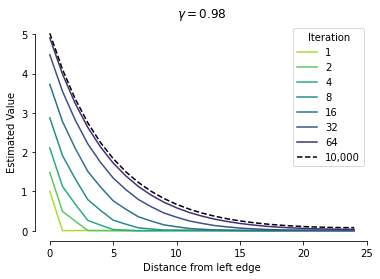

In [7]:
# define the enviornment
n_rows, n_columns = 1, 25

sparse_diffusion_matrix = utils.make_diffision_transition_matrix(n_rows, n_columns, sparse=True)

tiling = utils.define_lattice_tiling(n_rows, n_columns,)

R = np.ones(n_rows * n_columns) * 0
gamma = 0.98
R[0] = 1.0


V_0 = utils.draw_random_rewards(n_rows, n_columns, stdev=0.01)
V_a = V_0[:R.shape[0] // 2]
V_b = V_0[R.shape[0] // 2:]

k = 10000
V_estimates = np.zeros((R.shape[0], k+1))
V_estimates[tiling, 0] = V_a
V_estimates[~tiling, 0] = V_b


# dynamic programming algorithm
for ii in range(1, k+1):
    V_a =  R[tiling] + gamma * sparse_diffusion_matrix[tiling][:, ~tiling].dot(V_b)
    V_b =  R[~tiling] + gamma * sparse_diffusion_matrix[~tiling][:, tiling].dot(V_a)

    # save reward functions for measurements
    V_estimates[tiling, ii] = V_a
    V_estimates[~tiling, ii] = V_b
    
# plot the results
n_steps = 7
cc = sns.color_palette('viridis_r', n_colors=n_steps)
for ii in range(n_steps):
    plt.plot(V_estimates[:, 2**ii], label=f'{2**ii}', c=cc[ii])
plt.plot(V_estimates[:, -1], label=f'10,000', c='k', ls='--')
plt.ylabel('Estimated Value')
plt.xlabel('Distance from left edge')
plt.legend(title='Iteration')
plt.title(r'$\gamma={}$'.format(gamma))
sns.despine(trim=True)
plt.savefig('1dDrift_g98.pdf', dpi=300)


error_g98  = np.linalg.norm(V_estimates[:, 1:-1] - np.tile(V_estimates[:, -1].reshape(-1, 1), (1, k-1)), axis=0)



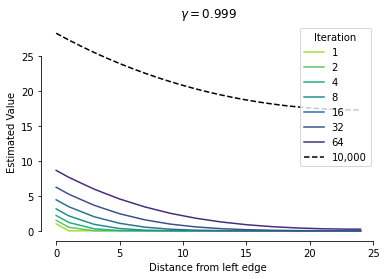

In [8]:
# define the enviornment
n_rows, n_columns = 1, 25

sparse_diffusion_matrix = utils.make_diffision_transition_matrix(n_rows, n_columns, sparse=True)

tiling = utils.define_lattice_tiling(n_rows, n_columns,)

R = np.ones(n_rows * n_columns) * 0
gamma = 0.999
R[0] = 1.0


V_0 = utils.draw_random_rewards(n_rows, n_columns, stdev=0.01)
V_a = V_0[:R.shape[0] // 2]
V_b = V_0[R.shape[0] // 2:]

k = 10000
V_estimates = np.zeros((R.shape[0], k+1))
V_estimates[tiling, 0] = V_a
V_estimates[~tiling, 0] = V_b


# dynamic programming algorithm
for ii in range(1, k+1):
    V_a =  R[tiling] + gamma * sparse_diffusion_matrix[tiling][:, ~tiling].dot(V_b)
    V_b =  R[~tiling] + gamma * sparse_diffusion_matrix[~tiling][:, tiling].dot(V_a)

    # save reward functions for measurements
    V_estimates[tiling, ii] = V_a
    V_estimates[~tiling, ii] = V_b
    
# plot the results
n_steps = 7
cc = sns.color_palette('viridis_r', n_colors=n_steps)
for ii in range(n_steps):
    plt.plot(V_estimates[:, 2**ii], label=f'{2**ii}', c=cc[ii])
plt.plot(V_estimates[:, -1], label=f'10,000', c='k', ls='--')
plt.ylabel('Estimated Value')
plt.xlabel('Distance from left edge')
plt.legend(title='Iteration')
plt.title(r'$\gamma={}$'.format(gamma))
sns.despine(trim=True)

error_g99  = np.linalg.norm(V_estimates[:, 1:-1] - np.tile(V_estimates[:, -1].reshape(-1, 1), (1, k-1)), axis=0)




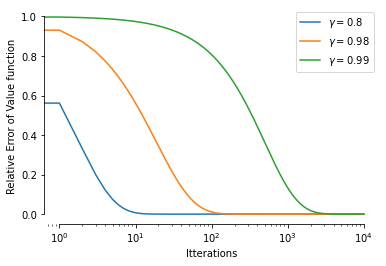

In [9]:
plt.plot(error_g08/np.max(error_g08), label=r'$\gamma = {}$'.format(0.8))
plt.plot(error_g98/np.max(error_g98), label=r'$\gamma = {}$'.format(0.98))
plt.plot(error_g99/np.max(error_g99), label=r'$\gamma = {}$'.format(0.99))
plt.xscale('log')
plt.legend()
plt.xlabel('Itterations')
plt.ylabel('Relative Error of Value function')
sns.despine(trim=True)
# plt.yscale()
plt.savefig('gamma_complexity.pdf', dpi=300)



## Example 3: Needle in a Haystack
This is designed as an example that is difficult for MCTS but easy for Value iteration. Note: these are the first simulations to derive a meaningful policy (the above were diffusion policies).


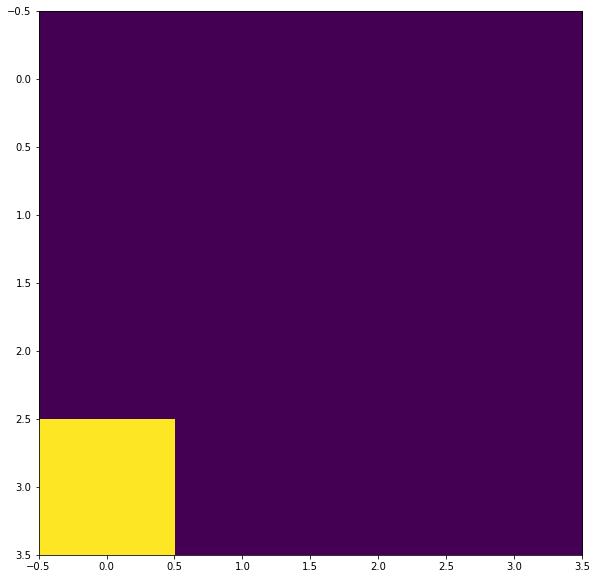

In [115]:
# define the enviornment
n_rows, n_columns = 4, 4

tiling = utils.define_lattice_tiling(n_rows, n_columns,)

# define the reward purely in terms of sucessor states
state_reward_function = np.ones(n_rows * n_columns) * 0
gamma = 0.95
state_reward_function[3 * n_columns + (n_columns // 8)] = 1.0



plt.figure(figsize=(10, 10))
plt.imshow(state_reward_function.reshape(n_rows, n_columns))

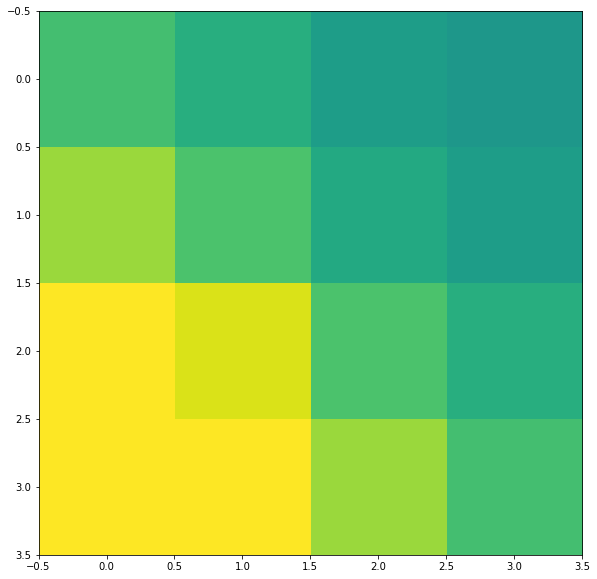

In [116]:
# show the Value function over states without regard to policy

sparse_diffusion_matrix = utils.make_diffision_transition_matrix(n_rows, n_columns, sparse=True)

V_0 = utils.draw_random_rewards(n_rows, n_columns, stdev=0.1)
V_a = V_0[:state_reward_function.shape[0] // 2]
V_b = V_0[state_reward_function.shape[0] // 2:]

k = 10000
V_estimates = np.zeros((state_reward_function.shape[0], k+1))
V_estimates[tiling, 0] = V_a
V_estimates[~tiling, 0] = V_b


# dynamic programming algorithm
for ii in range(1, k+1):
    V_a =  state_reward_function[tiling] + gamma * sparse_diffusion_matrix[tiling][:, ~tiling].dot(V_b)
    V_b =  state_reward_function[~tiling] + gamma * sparse_diffusion_matrix[~tiling][:, tiling].dot(V_a)

    # save reward functions for measurements
    V_estimates[tiling, ii] = V_a
    V_estimates[~tiling, ii] = V_b
    
plt.figure(figsize=(10, 10))
plt.imshow(V_estimates[:,k-1].reshape(n_rows, n_columns), cmap='viridis', vmin=0, vmax=1)
# plt.savefig('2dDrift_vf.pdf', dpi=300)

In [117]:
common_kwargs = dict(n_rows=n_rows, n_columns=n_columns)
transition_functions = utils.make_cardinal_transition_matrix(**common_kwargs)

state_action_reward_functions = utils.get_state_action_reward_from_sucessor_rewards(
    state_reward_function,transition_functions
)

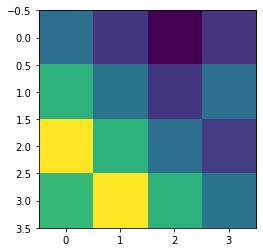

In [121]:
Q, R = utils.value_iteration(transition_functions, state_action_reward_functions, **common_kwargs, iterations=5000)
plt.imshow(R.reshape(n_rows, n_columns))

In [122]:
np.argmax(Q, axis=1).reshape(n_rows, n_columns)

array([[3, 3, 3, 3],
       [3, 3, 3, 1],
       [3, 3, 3, 3],
       [2, 1, 1, 1]])

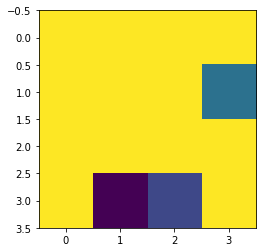

In [125]:
plt.imshow(Q[:, 3].reshape(n_rows, n_columns) - R.reshape(n_rows, n_columns))

In [126]:
Q.shape

array([[1.20320086, 1.01996327, 0.99311214, 1.57686086],
       [1.11823494, 1.254326  , 0.82986595, 1.26289899],
       [1.00100695, 0.99216433, 0.99216433, 1.00940744],
       [1.03464695, 0.818882  , 0.818882  , 1.23962366],
       [1.27499395, 1.27499395, 1.28515539, 2.00948059],
       [1.03024508, 1.03024508, 1.5787175 , 1.60711275],
       [0.82487384, 1.26264938, 1.26181202, 1.26289371],
       [1.00009384, 1.57720994, 1.03865972, 1.02928439],
       [1.61741544, 1.62488098, 1.05859546, 2.55950371],
       [1.30446061, 2.01044585, 1.3003254 , 2.01075904],
       [1.02057852, 1.02838033, 1.02838033, 1.5786883 ],
       [1.26221158, 1.26291369, 1.26291369, 1.2859887 ],
       [2.04761665, 2.04761665, 2.04812361, 2.04812361],
       [1.62602119, 2.56018786, 1.68458333, 1.68458333],
       [1.27644151, 2.00956485, 1.32332125, 1.32332125],
       [1.04860044, 1.60900396, 1.60771948, 1.60771948]])

In [108]:
print(transition_functions[1])

[[0.00000000e+00 5.00000000e-01 0.00000000e+00 0.00000000e+00
  0.00000000e+00 5.00000000e-01 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [9.66666667e-01 0.00000000e+00 1.66666667e-02 0.00000000e+00
  0.00000000e+00 0.00000000e+00 1.66666667e-02 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 9.66666667e-01 0.00000000e+00 1.66666667e-02
  0.00000000e+00 0.00000000e+00 0.00000000e+00 1.66666667e-02
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.

In [114]:
T = utils.make_cardinal_transition_matrix(**common_kwargs)
T[0]

array([[0.        , 0.5       , 0.        , 0.        , 0.        ,
        0.5       , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.33333333, 0.        , 0.33333333, 0.        , 0.        ,
        0.        , 0.33333333, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.33333333, 0.        , 0.33333333, 0.        ,
        0.        , 0.        , 0.33333333, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.